In [1]:
dataset = 'macosko2015'
algorithm = 'phate'
n_components = 2
dims = (50,)

In [2]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


### load packages

In [4]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/umap.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [6]:
from tensorflow.keras.datasets import mnist

In [7]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

import gzip
import pickle

with gzip.open(DATA_DIR / 'macosko_2015.pkl.gz', "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

def zero_one_norm(x):
    return (x- np.min(x, axis=0))/ (np.max(x, axis=0)-np.min(x, axis=0))

x_norm = zero_one_norm(x)

print("Data set contains %d samples with %d features" % x.shape)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x_norm, y, test_size=.1, random_state=42)

n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

X_train_flat = X_train
X_test_flat = X_test

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

Y_train = enc.fit_transform([[i] for i in Y_train]).flatten()
Y_test = enc.fit_transform([[i] for i in Y_test]).flatten()

Data set contains 44808 samples with 50 features


### Create model and train

In [8]:
import phate

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

X_scaled = MinMaxScaler().fit_transform(X_train_flat)

In [10]:
phate_op = phate.PHATE(n_jobs=-1)
z = data_phate = phate_op.fit_transform(X_scaled)

Calculating PHATE...
  Running PHATE on 30327 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 31.24 seconds.
    Calculating affinities...
    Calculated affinities in 3.41 seconds.
  Calculated graph and diffusion operator in 34.68 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 3.94 seconds.
    Calculating KMeans...
    Calculated KMeans in 15.57 seconds.
  Calculated landmark operator in 21.15 seconds.
  Calculating optimal t...
    Automatically selected t = 52
  Calculated optimal t in 1.74 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.66 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.71 seconds.
Calculated PHATE in 65.95 seconds.


### Plot model output

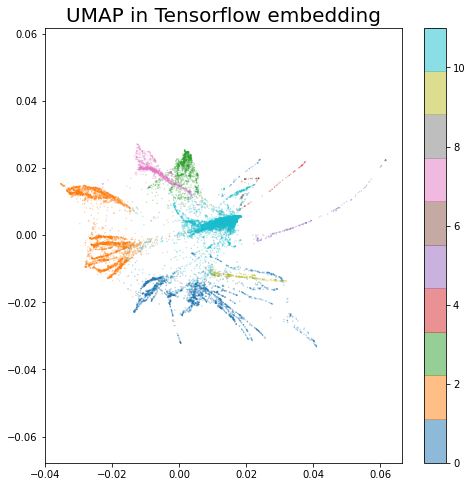

In [11]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### Save output

In [12]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [13]:
output_dir = MODEL_DIR/'projections'/ dataset / algorithm
ensure_dir(output_dir)

In [14]:
#vae.save(output_dir)

In [15]:
#loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [16]:
np.save(output_dir / 'z.npy', z)

### compute metrics 

In [17]:
X_test.shape

(4481, 50)

In [18]:
z_test = phate_op.transform(X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:]))))

Calculating KNN search...


/home/AD/tsainbur/anaconda3/envs/tfumap/lib/python3.7/site-packages/phate/phate.py:881: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  RuntimeWarning,


Calculated KNN search in 5.05 seconds.
Calculating affinities...
Calculated affinities in 8.43 seconds.


#### silhouette

In [19]:
from tfumap.silhouette import silhouette_score_block

In [20]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

0.4723423724567551

In [21]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

0.4863649376669434

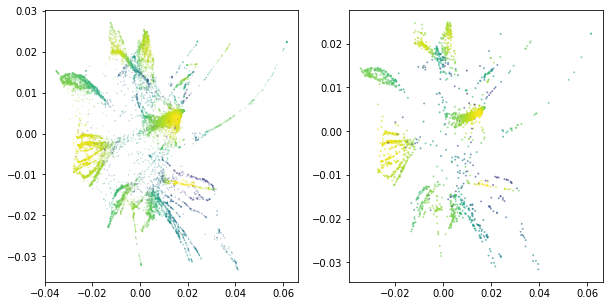

In [22]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

0.9678643160008926

In [25]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

0.9582682436956037

#### Trustworthiness

In [26]:
from sklearn.manifold import trustworthiness

In [27]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [28]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [29]:
tw, tw_test

(0.8870510468374699, 0.8704491972041029)

### Save output metrics

In [30]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

#### train

In [31]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, algorithm, n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,macosko2015,phate,2,0.887051,0.472342,"[0.5580451385498394, 0.5547430483940562, 0.256..."


In [32]:
save_loc = DATA_DIR / 'projection_metrics' /  algorithm / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### test

In [33]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, algorithm, n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,macosko2015,phate,2,0.870449,0.486365,"[0.6697749261708856, 0.3071744669826735, 0.689..."


In [34]:
save_loc = DATA_DIR / 'projection_metrics' / algorithm / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### knn 

In [35]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = [algorithm, n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,phate,2,macosko2015,0.958268,0.967864


In [36]:
save_loc = DATA_DIR / 'knn_classifier' / algorithm / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)

### Compute clustering quality

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure

In [38]:
def get_cluster_metrics(row, n_init=5):
    
    # load cluster information
    save_loc = DATA_DIR / 'clustering_metric_df'/ ('_'.join([row.class_, str(row.dim), row.dataset]) + '.pickle')
    print(save_loc)
    if save_loc.exists() and save_loc.is_file():
        
        cluster_df = pd.read_pickle(save_loc)
        return cluster_df
    
    # make cluster metric dataframe
    cluster_df = pd.DataFrame(
        columns=[
            "dataset",
            "class_",
            "dim",
            "silhouette",
            "homogeneity",
            "completeness",
            "v_measure",
            "init_",
            "n_clusters",
            "model",
        ]
    )
    y = row.train_label
    z = row.train_z
    n_labels = len(np.unique(y))
    for n_clusters in tqdm(np.arange(n_labels - int(n_labels / 2), n_labels + int(n_labels / 2)), leave=False, desc = 'n_clusters'):
        for init_ in tqdm(range(n_init), leave=False, desc='init'):
            kmeans = KMeans(n_clusters=n_clusters, random_state=init_).fit(z)
            clustered_y = kmeans.labels_
            homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(
                y, clustered_y
            )
            ss, _ = silhouette_score_block(z, clustered_y)
            cluster_df.loc[len(cluster_df)] = [
                row.dataset,
                row.class_,
                row.dim,
                ss,
                homogeneity,
                completeness,
                v_measure,
                init_,
                n_clusters,
                kmeans,
            ]
    
     # save cluster df in case this fails somewhere
    ensure_dir(save_loc)
    cluster_df.to_pickle(save_loc)
    return cluster_df

In [39]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label', 'dim'])
projection_df.loc[len(projection_df)] = [dataset, algorithm, z, Y_train, n_components]
projection_df

,dataset,class_,train_z,train_label,dim
0,macosko2015,phate,"[[0.011059872976151196, 0.0025136312694616953]...","[10.0, 7.0, 0.0, 10.0, 10.0, 10.0, 10.0, 10.0,...",2


In [40]:
get_cluster_metrics(projection_df.iloc[0], n_init=5)

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/clustering_metric_df/phate_2_macosko2015.pickle


,dataset,class_,dim,silhouette,homogeneity,completeness,v_measure,init_,n_clusters,model
0,macosko2015,phate,2,0.614372,0.581859,0.537320,0.558703,0,6,"KMeans(n_clusters=6, random_state=0)"
1,macosko2015,phate,2,0.613803,0.582278,0.537084,0.558768,1,6,"KMeans(n_clusters=6, random_state=1)"
2,macosko2015,phate,2,0.614321,0.581788,0.537216,0.558614,2,6,"KMeans(n_clusters=6, random_state=2)"
3,macosko2015,phate,2,0.613961,0.582114,0.537239,0.558777,3,6,"KMeans(n_clusters=6, random_state=3)"
4,macosko2015,phate,2,0.614275,0.581853,0.537138,0.558602,4,6,"KMeans(n_clusters=6, random_state=4)"
5,macosko2015,phate,2,0.549549,0.601784,0.484771,0.536977,0,7,"KMeans(n_clusters=7, random_state=0)"
6,macosko2015,phate,2,0.544831,0.601295,0.481722,0.534908,1,7,"KMeans(n_clusters=7, random_state=1)"
7,macosko2015,phate,2,0.550949,0.601715,0.485697,0.537517,2,7,"KMeans(n_clusters=7, random_state=2)"
8,macosko2015,phate,2,0.552156,0.601733,0.486606,0.538080,3,7,"KMeans(n_clusters=7, random_state=3)"
9,macosko2015,phate,2,0.545864,0.601294,0.482204,0.535204,4,7,"KMeans(n_clusters=7, random_state=4)"
